In [4]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2025-04-21 10:14:29.463056: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-21 10:14:29.756354: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-21 10:14:29.917745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745230470.177094    5944 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745230470.279462    5944 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745230470.881971    5944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin


Specify each path

In [16]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [26]:
## Set number of classes

NUM_CLASSES = np.max(y_dataset) + 1

In [27]:
## Dataset reading

X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [28]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

Model Building

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [31]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_4 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,136 (4.44 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Model checkpoint callback

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

# Callback for early stopping

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [33]:
# Model compilation

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model Training


In [34]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


 1/38 ━━━━━━━━━━━━━━━━━━━━ 33s 913ms/step - accuracy: 0.0938 - loss: 2.0057
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1425 - loss: 1.8836 - val_accuracy: 0.3337 - val_loss: 1.6243
Epoch 2/1000
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2711 - loss: 1.6692 
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2814 - loss: 1.6600 - val_accuracy: 0.5508 - val_loss: 1.4944
Epoch 3/1000
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2969 - loss: 1.5794
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3917 - loss: 1.5415 - val_accuracy: 0.6326 - val_loss: 1.3145
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4639 - loss: 1.3951 
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras
38/38 ━━━━

In [35]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.1304 


In [36]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [37]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[1.1557811e-03 1.4932804e-01 4.8261956e-18 3.2611544e-14 8.4951621e-01
 4.8465882e-08]
4


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


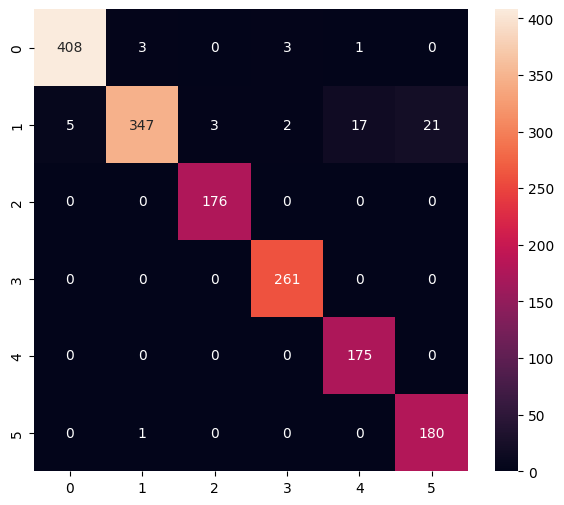

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       415
           1       0.99      0.88      0.93       395
           2       0.98      1.00      0.99       176
           3       0.98      1.00      0.99       261
           4       0.91      1.00      0.95       175
           5       0.90      0.99      0.94       181

    accuracy                           0.97      1603
   macro avg       0.96      0.98      0.97      1603
weighted avg       0.97      0.97      0.96      1603



In [38]:
## Confusion Matrix

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

Model conversion for Tensorflow-Lite

In [39]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [40]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpkezfb0cb/assets


INFO:tensorflow:Assets written to: /tmp/tmpkezfb0cb/assets


Saved artifact at '/tmp/tmpkezfb0cb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133241375263056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133241375266128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133241375265168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133241272489488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133241272493136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133241272490256: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1745231384.895143    5944 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745231384.895181    5944 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-21 10:29:44.895699: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkezfb0cb
2025-04-21 10:29:44.897245: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-21 10:29:44.897259: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpkezfb0cb
I0000 00:00:1745231384.920263    5944 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-21 10:29:44.925241: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-21 10:29:44.976203: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpkezfb0cb
2025-04-21 10:29:44.998677: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

6644

Inference test

In [41]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

/usr/local/python/3.12.1/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [43]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [44]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 31 μs, sys: 1 ms, total: 1.03 ms
Wall time: 2.32 ms


In [45]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.1557781e-03 1.4932771e-01 4.8261783e-18 3.2611622e-14 8.4951645e-01
 4.8465807e-08]
4
